# Gross-Vitells LEE for a bump hunt with two channels

## Preliminaries

This is a continuation of the notebook showing how to calculate excursion probabilities in the presence of one or more unknown signal parameters in a search for new physics.  Previously I had shown how this can be done for the case of the discovery of the Higgs boson and focused on the two "golden" channels: $h_{0}\rightarrow \gamma\gamma$ and $h_{0}\rightarrow ZZ \rightarrow 4\ell$.  As before, we'll carry out an unbinned MLE for the model parameters, but this time both channels will be fit simultaneously with the signal parameters $\mu$ and $\sigma$ fixed to be the same in both channels.

The important distinction between this approach and the case of the individual channels is that we will now minimize the combined likelihood:

$$
\mathcal{L} = -\sum \log f_{\gamma\gamma}(x_{\gamma\gamma,i};\boldsymbol{\alpha}_{\gamma\gamma}, \mu, \sigma) - \sum \log f_{ZZ}(x_{ZZ,i};\boldsymbol{\alpha}_{ZZ}, \mu, \sigma),
$$

where each channel has its own background parameterization, $\boldsymbol{\alpha}$, but the same signal parameters: the center of the resonance, $\mu$, and its width, $\sigma$.

## Simultaneous fit

In [1]:
# imports and configuration

%cd '/home/naodell/work/nllfit'
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import legval
from scipy.stats import norm, chi2
from tqdm import tqdm_notebook

from nllfit import Parameters, ScanParameters, Model, CombinedModel, NLLFitter
import nllfit.fit_tools as ft
import nllfit.lookee as lee


/home/naodell/work/nllfit


In [2]:
# plot of toy data
datasets = []
df_data  = pd.read_csv('data/toy_hgammagamma.txt')
datasets.append(df_data.diphoton_mass.values)

df_data  = pd.read_csv('data/toy_hzz.txt')
datasets.append(df_data.inv_mass.values)

df_bg       = pd.read_csv('data/toy_hzz_bg.txt')
data_hzz_bg = df_bg.inv_mass.values[:7500]

xlimits  = (100, 180)

Next, define the background and signal models. For the background, a third-order Legendre polynomial is used.  For the signal, a Gaussian will be used, though a Voigt profile would be more accurate.  Ultimately, both are characteristically the same in that they are fully specified by the location of the central value and the width of the lineshape.  The bounds on $\mu$ and $\sigma$ should be set to correspond to the scan range.  In this case the bounds for $\mu$ are set to be 5 GeV below/above the maximum/minimum values saved in data.

In [3]:
### pdf definitions
def bg_pdf(x, a, bnds=(100, 180)):                                                              
    '''                                                                        
    Wrapper for nth order Legendre Polynomial.            
                                                                               
    Parameters:                                                                
    ===========                                                                
    x: data                                                                    
    a: model parameters (a1 and a2)                                            
    '''      
    z   = ft.scale_data(x, xmin=bnds[0], xmax=bnds[1])                                      
    fx  = legval(z, a)*2/(bnds[1] - bnds[0])                             
    return fx                                                                  

def sig_pdf(x, a, normalize=False):                                            
    '''                                                                        
    Second order Legendre Polynomial (normalized to unity) plus a Gaussian.    
                                                                               
    Parameters:                                                                
    ===========                                                                
    x: data                                                                    
    a: model parameters (a1, a2, mu, and sigma)                                
    '''                                                                        
                                                                               
    bg = bg_pdf(x, a[3:])                                                     
    sig = norm.pdf(x, a[1], a[2])                                              
    if normalize:                                                              
        sig_norm = integrate.quad(lambda z: norm.pdf(z, a[1], a[2]), -1, 1)[0] 
    else:                                                                      
        sig_norm = 1.                                                          
                                                                               
    return (1 - a[0])*bg + a[0]*sig/sig_norm                                   


In [4]:
### Fit single models to initialize parameters
### Define bg model and carry out fit 
bg1_params = Parameters()
bg1_params.add_many(
                   ('a0', 0.5, False, None, None, None),
                   ('a1', 0., True, None, None, None),
                   ('a2', 0., True, None, None, None),
                   ('a3', 0., True, None, None, None)
                  )
bg1_model  = Model(bg_pdf, bg1_params)
bg1_fitter = NLLFitter(bg1_model, verbose=False)
bg1_result = bg1_fitter.fit(datasets[0])

bg2_params = Parameters()
bg2_params.add_many(
                   ('b0', 0.5, False, None, None, None),
                   ('b1', 0., True, None, None, None),
                   ('b2', 0., True, None, None, None),
                   ('b3', 0., True, None, None, None)
                  )
bg2_model  = Model(bg_pdf, bg2_params)
bg2_fitter = NLLFitter(bg2_model, verbose=False)
bg2_result = bg2_fitter.fit(data_hzz_bg)

bg2_params['b1'].vary   = False
bg2_params['b2'].vary   = False
bg2_params['b3'].vary   = False

### Define bg+sig model and carry out fit ###
sig1_params = Parameters()
sig1_params.add_many(
                    ('A1'    , 0.01 , True , 0.   , 1.   , None),
                    ('mu'    , 125. , True , 120., 150.  , None),
                    ('sigma' , 2.0  , True , 1.   , 5.   , None)
                   )
sig1_params += bg1_params.copy()
sig1_model  = Model(sig_pdf, sig1_params)
sig1_fitter = NLLFitter(sig1_model, verbose=False)
sig1_result = sig1_fitter.fit(datasets[0])

sig2_params = Parameters()
sig2_params.add_many(
                    ('A2'    , 0.01 , True , 0.   , 1.   , None),
                    ('mu'    , 125.  , True , 120.  , 150.  , None),
                    ('sigma' , 2.0  , True , 1. , 5.   , None)
                   )
sig2_params += bg2_params.copy()
sig2_model  = Model(sig_pdf, sig2_params)
sig2_fitter = NLLFitter(sig2_model, verbose=False)
sig2_result = sig2_fitter.fit(datasets[1])

nllfit/model.py:131: RuntimeWarning: invalid value encountered in log
  nll = -np.sum(np.log(pdf))
nllfit/model.py:131: RuntimeWarning: divide by zero encountered in log
  nll = -np.sum(np.log(pdf))


Combining the two channels is made easy using the handy `CombinedModel` class.  All that's needed is to pass in the individual `Model` instances as a list.  Then when you fit the data pass in the data as a list where the order corresponds to the order the `Model` instances were passed into the `CombinedModel` instance.

In [16]:
### Carry out simultaneous MLE with background model
bg_model  = CombinedModel([bg1_model, bg2_model])
bg_fitter = NLLFitter(bg_model, verbose=True)
bg_result = bg_fitter.fit(datasets)

### Carry out simultaneous MLE with bg+signal model
sig_model  = CombinedModel([sig1_model, sig2_model])
sig_fitter = NLLFitter(sig_model, verbose=True)
sig_result = sig_fitter.fit(datasets)

Fit finished with status: 0
[[Variables]]
    a0:   0.5 (fixed)
    a1:  -0.48139596 +/- 0.009167 (1.90%) (init= 0)
    a2:   0.18294692 +/- 0.011612 (6.35%) (init= 0)
    a3:  -0.04536341 +/- 0.012026 (26.51%) (init= 0)
    b0:   0.5 (fixed)
    b1:  -0.05247548 (fixed)
    b2:   0.00046844 (fixed)
    b3:   0.09257463 (fixed)

[[Correlation matrix]]
[[ 1.    -0.52   0.156 -0.037  0.     0.     0.     0.   ]
 [-0.52   1.    -0.472  0.145  0.     0.     0.     0.   ]
 [ 0.156 -0.472  1.    -0.463  0.     0.     0.     0.   ]
 [-0.037  0.145 -0.463  1.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     1.    -0.239  0.253 -0.197]
 [ 0.     0.     0.     0.    -0.239  1.    -0.317  0.373]
 [ 0.     0.     0.     0.     0.253 -0.317  1.    -0.139]
 [ 0.     0.     0.     0.    -0.197  0.373 -0.139  1.   ]] 

Fit finished with status: 0
[[Variables]]
    A1:      3.7768e-14 +/- nan      (nan%) (init= 0.01)
    mu:      150        +/- nan      (nan%) (init= 125)
    sigma:   5  

nllfit/nllfitter.py:71: RuntimeWarning: invalid value encountered in sqrt
  sig = np.sqrt(hinv.diagonal())


Note that the signal model is the mixture of the background polynomial and the Gaussian.  In both cases, the models are fit to the data so that we can use the parameters for generating MC.  It will be important to know the value of the likelihood ratio so that we can later determine the corresponding global p value.

In [6]:
qmax = 2*(bg_model.calc_nll(datasets) - sig_model.calc_nll(datasets))
qmax

72.159884157881606

As in the single channel case, we generate a number simulated datasets and generate a number of scan points.

In [7]:
### Generate toy MC ###
sims = []
nsims = 1000
for model, dataset in zip(bg_model.models, datasets):
    simdata = ft.generator(model.pdf, xlimits, ntoys=nsims*dataset.size)
    sims.append(simdata.reshape(nsims, dataset.size))
sims = zip(sims[0], sims[1])

# define scan parameters
sig_params = sig_model.get_parameters()
sigma_max  = sig_params['sigma'].value
nscans     = [30, 10]
bnds       = [(xlimits[0]+10, xlimits[1]-10), (1, 5)]

scan_params = ScanParameters(names  = ['mu', 'sigma'],
                             bounds = bnds,
                             nscans = nscans
                            )

This is where we get into new stuff.  In order to appropriately account for bounds on the signal strength parameters (they should be non-negative), the GV expansion needs to modified to account for this,

$$
\mathbb{E}[\phi(A_{u})] =                                                 
\frac{1}{4}\delta_{0}(u)                                                 
+ \frac{1}{4}\sum_{d=0}^{D}\mathcal{N}^{\gamma\gamma}_{d}\rho_{d}(u;d,1)      
+ \frac{1}{4}\sum_{d=0}^{D}\mathcal{N}^{ZZ}_{d}\rho_{d}(u;d,1)        
+ \frac{1}{4} \sum_{d=0}^{D}\mathcal{N}^{\gamma\gamma + ZZ}_{d}\rho_{d}(u;d,2)
$$

The coefficients for the middle two expressions are determined independently for each channel (these correspond to $A_{\gamma\gamma} > 0$ and $A_{ZZ} \leq 0$ or $A_{\gamma\gamma} \leq 0$ and $A_{ZZ} > 0$).  The last term accounts for the case that both channels have positive amplitude fluctuations.  That these three components are treated separately while scanning and then subsequently determining the the coefficients is very important and is needed because of the degeneracy (or non-orthogonality) of the EC densities $\rho_{d}$.

In [8]:
# carry out scans of signal parameters and cacluate EC for varying excursions
paramscan = []
qmaxscan  = []
dofs      = []
phiscan   = [[], [], []]
u_0       = np.linspace(0.2, 30., 149)
for i, sim in tqdm_notebook(enumerate(sims), 
                            desc       = 'scanning',
                            unit_scale = True,
                            ncols      = 75,
                            total      = len(sims)
                           ):
    sim = list(sim) # fitter doesn't like tuples for some reason... 

    # fit background model
    bg1_result = bg1_fitter.fit(sim[0])
    bg2_result = bg2_fitter.fit(sim[1])
    bg_result  = bg_fitter.fit(sim)
    if bg_result.status == 0:
        nll_bg1 = bg1_model.calc_nll(sim[0], bg1_result.x)
        nll_bg2 = bg2_model.calc_nll(sim[1], bg2_result.x)
        nll_bg  = bg_model.calc_nll(sim, bg_result.x)
    else:
        continue

    # scan over signal parameters (1b1f)
    nllscan, _, _ = sig1_fitter.scan(scan_params, sim[0]) 
    qscan = -2*(nllscan - nll_bg1)

    ### Calculate E.C. of the random field
    if qscan.size != np.prod(scan_params.nscans): 
        continue

    qscan = np.array(qscan).reshape(nscans)
    phiscan[0].append(np.array([lee.calculate_euler_characteristic((qscan > u) + 0.) for u in u_0]))

    # scan over signal parameters (1b1c)
    nllscan, _, _ = sig2_fitter.scan(scan_params, sim[1]) 
    qscan = -2*(nllscan - nll_bg2)

    ### Calculate E.C. of the random field
    if qscan.size != np.prod(scan_params.nscans): 
        continue

    qscan = np.array(qscan).reshape(nscans)
    phiscan[1].append(np.array([lee.calculate_euler_characteristic((qscan > u) + 0.) for u in u_0]))
    # scan over signal parameters
    nllscan, params, dof = sig_fitter.scan(scan_params, sim, amps=[0, 5]) 
    qscan = -2*(nllscan - nll_bg)

    ### Calculate E.C. of the random field
    if qscan.size != np.prod(scan_params.nscans): 
        continue

    qscan = np.array(qscan).reshape(nscans)
    phiscan[2].append(np.array([lee.calculate_euler_characteristic((qscan > u) + 0.) for u in u_0]))
    paramscan.append(params)
    qmaxscan.append(np.max(qscan))
    dofs.append(dof)

#     if make_plots and i < 50:
#         #for j, channel in enumerate(channels):
#         #    ft.fit_plot(sim[j], xlimits, sig_model.models[j], bg_model.models[j],
#         #               'simultaneous_{0}_{1}'.format(channel,i+1), path='plots/scan_fits')

#         if ndim == 1:
#             ft.plot_pvalue_scan_1D(qscan.flatten(), mu, 
#                                    path ='plots/scan_fits/pvalue_scans_{0}_{1}_1D.png'.format(channel, i+1))
#         if ndim == 2:
#             ft.plot_pvalue_scan_2D(qscan.flatten(), mu, sigma,
#                                    path ='plots/scan_fits/pvalue_scans_{0}_{1}_2D.png'.format(channel, i+1))

phiscan   = [np.array(ps) for ps in phiscan]
paramscan = np.array(paramscan)
qmaxscan  = np.array(qmaxscan)
dofs      = np.array(dofs)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Having completed the scans and calculated the corresponding EC, the coefficients for the EC densities can be determined.  This is done by carrying out a fit to the scan data.

In [12]:
# determine coefficients for GV expansion

ndim    = 2
nvals1  = lee.get_GV_coefficients(u_0, phiscan[0], 
                                  p_init = ndim*[1.,],
                                  p_bnds = ndim*[(0., np.inf), ],
                                  kvals  = [1], 
                                  scales = [0.5]
                                 )
nvals2  = lee.get_GV_coefficients(u_0, phiscan[1], 
                                  p_init = ndim*[1.,],
                                  p_bnds = ndim*[(0., np.inf), ],
                                  kvals  = [1], 
                                  scales = [0.5]
                                 )

prebounds = [(n, n) for n in np.concatenate((nvals1, nvals2))] + ndim*[(0., np.inf),]
preinit   = np.concatenate((nvals1, nvals2, ndim*[1.,]))
kvals     = [1, 1, 2]
scales    = [0.25, 0.25, 0.25]
nvals     = lee.get_GV_coefficients(u_0, phiscan[2],
                                    p_init = preinit,
                                    p_bnds = prebounds, 
                                    kvals  = kvals,
                                    scales = scales
                                   )
nvals = np.reshape(nvals, (3, ndim))

Finally, calculate the relevant statistics and print the results,

In [13]:
### Calculate statistics ###
p_local  = 0.5*chi2.sf(qmax, 1) + 0.25*chi2.sf(qmax, 2) # according to Chernoff 
z_local  = -norm.ppf(p_local)
p_global = lee.get_p_global(qmax, kvals, nvals, scales)
z_global = -norm.ppf(p_global)

for i, n in enumerate(nvals.flatten()):
    print 'N{0} = {1:.2f}'.format(i+1, n)

print ''
print 'local p value       = {0:.3e}'.format(p_local)
print 'local significance  = {0:.2f}'.format(z_local)
print 'global p value      = {0:.3e}'.format(p_global)
print 'global significance = {0:.2f}'.format(z_global)
print 'trial factor        = {0:.2f}'.format(p_global/p_local)

N1 = 29.10
N2 = 26.67
N3 = 26.57
N4 = 16.32
N5 = 15.67
N6 = 31.19

local p value       = 6.346e-17
local significance  = 8.28
global p value      = 2.525e-14
global significance = 7.53
trial factor        = 397.94


For the sake of validating this result we can check if our prediction from the Gross-Vitells formalism compares well with the distribution from the toy data.

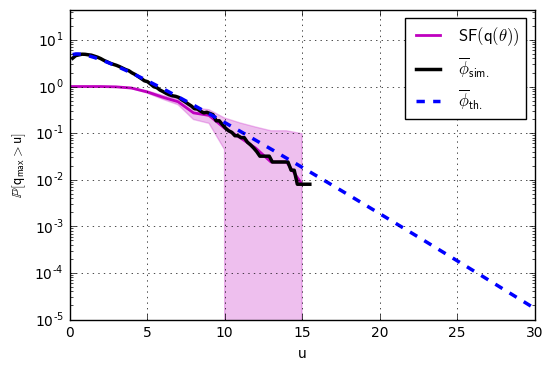

In [14]:
lee.gv_validation_plot(u_0, phiscan[-1], qmaxscan, 
                       nvals, kvals, scales, None)
#                        channel='simultaneous_{0}D'.format(ndim))